In [1]:
#Script: Tutorial for generating consensus GOF/LOF signature
#Author: Somnath Tagore, Ph.D.
#Date of Creation: 02/24/2025

#Note: The following tutorial creates a consensus GOF/LOF signature for a toy example.
#Note: The signature is generated for PIK3CA gene in BLCA-TCGA cohort.


In [2]:
#Libraries
library(pheatmap)
library(RColorBrewer)
library(viper)
library(fpc)
library(cluster)
library(pheatmap)
library(RColorBrewer)
library(org.Hs.eg.db)
library(annotate)
library(rmarkdown)

#Custom functions for plotting
quantile_breaks <- function(xs, n = 10){
  breaks <- quantile(xs, probs = seq(from = 0, to = 1, length.out = n))
  unique(breaks)
}

gg_color_hue <- function(n) {
  hues = seq(15, 375, length = n + 1)
  hcl(h = hues, l = 65, c = 100)[1:n]
}

save_pheatmap_pdf <- function(x, filename, width=10, height=10) {
  stopifnot(!missing(x))
  stopifnot(!missing(filename))
  pdf(filename, width=width, height=height)
  grid::grid.newpage()
  grid::grid.draw(x$gtable)
  dev.off()
}

outersect <- function(x,y){
  sort(c(setdiff(x,y),setdiff(y,x)))
}


Loading required package: Biobase

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.


Loading required package: AnnotationDbi

Loading required package: stats4

Loading required package: IRanges

Loading required package: S4Vectors

In [3]:
# tcga tumor blca data
blca.tumor<-read.table(file="../../PIK3CA_BLCA/blca-tcga-tumor.txt", header=TRUE)
dim(blca.tumor)

# tcga normal blca data
blca.normal<-read.table(file="../../PIK3CA_BLCA/blca-tcga-normal.txt", header=TRUE)
dim(blca.normal)


[1] 18133   362

[1] 18133    17

In [4]:
#removing #N/A from samples
tcga.normal<-blca.normal
tcga.tumor<-blca.tumor
tcga.normal <- tcga.normal[is.finite(rowSums(tcga.normal)),]
tcga.tumor <- tcga.tumor[is.finite(rowSums(tcga.tumor)),]
any(is.na(tcga.normal))
any(is.na(tcga.tumor))

#check for identical genes
identical(rownames(tcga.tumor),rownames(tcga.normal))
table(rownames(tcga.tumor)%in%rownames(tcga.normal))
common_genes <- intersect(rownames(tcga.tumor),rownames(tcga.normal))
length(common_genes)

tcga.tumor <- tcga.tumor[match(common_genes,rownames(tcga.tumor)),]
tcga.normal <- tcga.normal[match(common_genes,rownames(tcga.normal)),]
identical(rownames(tcga.normal),rownames(tcga.tumor))

#combine tumor, normal data
mixed.tcga.tumor.normal <- cbind(tcga.tumor, tcga.normal)
dim(mixed.tcga.tumor.normal)

#check na data
any(is.na(mixed.tcga.tumor.normal))

#log2cpm+1 normalization
mixed.tcga.tumor.normal.log2cpm <- apply(mixed.tcga.tumor.normal,2,function(x){
  y <- 1E6*x/sum(x) + 1
  z <- log(y,2)
  return(z)
})
mixed.tcga.tumor.normal.log2cpm.ges <- t(apply(mixed.tcga.tumor.normal.log2cpm,1,function(x){
  y <- (x - mean(x))/sd(x)
  return(y)
}))


[1] FALSE

[1] FALSE

[1] TRUE


 TRUE 
18133 

[1] 18133

[1] TRUE

[1] 18133   379

[1] FALSE


Computing the association scores

Computing regulons enrichment with aREA



  |======================================================================| 100%

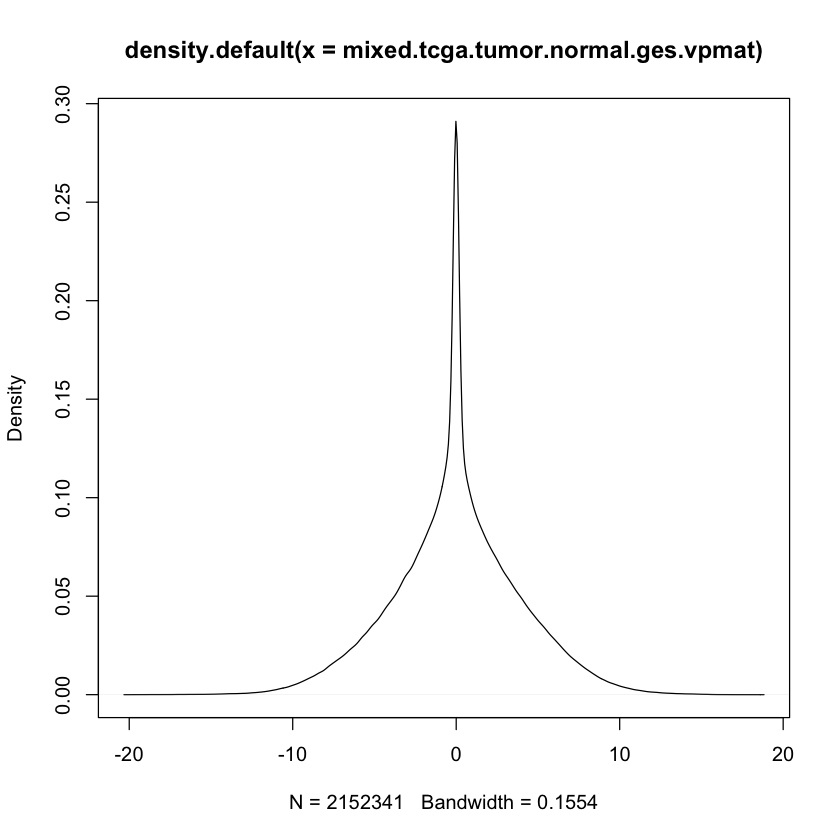

In [5]:
#load the blca regulon
load('../../PIK3CA_BLCA/blca_regulon.rda')

#pruning the regulon
pregul.blca <- pruneRegulon(regul, cutoff = 50)

#inferring protein activity
mixed.tcga.tumor.normal.ges.vpmat <- viper(eset = mixed.tcga.tumor.normal.log2cpm.ges, regulon = pregul.blca, method = "none")

#saving the object
saveRDS(mixed.tcga.tumor.normal.ges.vpmat,file="blca.mixed.tcga.tumor.normal.ges.vpmat.rds")

#pdf('density_estimation.pdf')
plot(density(mixed.tcga.tumor.normal.ges.vpmat))
#dev.off()


In [9]:
#calculating viper similarity
tumor.vpmat<-mixed.tcga.tumor.normal.ges.vpmat
dim(tumor.vpmat)
any(is.na(tumor.vpmat))
vipsim <- viperSimilarity(tumor.vpmat)
dist.matr <- as.dist(vipsim)

#pamk clustering
pam.clust<-pamk(dist.matr,krange=2:10,criterion="asw", usepam=TRUE,
                scaling=FALSE, alpha=0.001, diss=inherits(data, "dist"),
                critout=FALSE, ns=10, seed=NULL)
#pam.clust$nc

current.silinfo <- as.data.frame(pam.clust$pamobject$silinfo$widths)

current.bootsil <- lapply(1:1000,function(x,ref.clust,ref.dist){
  y <- sample(x = ref.clust, size = length(ref.clust), replace = FALSE)
  z <- silhouette(x = y, dist = dist.matr)[,3]
  return(z)
}, ref.clust = as.numeric(pam.clust$pamobject$clustering), ref.dist = dist.matr)
current.bootsil <- unlist(current.bootsil)

# compute true silhouette score right-tailed p-values
current.silinfo$pvalue <- pnorm(q = current.silinfo$sil_width, 
                                mean = mean(current.bootsil), sd = sd(current.bootsil), 
                                lower.tail = FALSE) - pnorm(q = 1, 
                                                            mean = mean(current.bootsil), 
                                                            sd = sd(current.bootsil), 
                                                            lower.tail = FALSE)

# adjust p-values for FDR 
current.silinfo$padj <- p.adjust(current.silinfo$pvalue, method = "BH")

# order the silhouette score info by cluster and silhoeutte score
current.silinfo <- current.silinfo[order(current.silinfo$cluster, current.silinfo$sil_width, decreasing = TRUE),]

# plot distance matrix after rearranging the results by silhouette score and cluster annotations
annot.col <- current.silinfo[,c("cluster","sil_width")]
colnames(annot.col) <- c("Cluster","SilScore")
annot.col$Cluster <- factor(annot.col$Cluster, 
                            levels = sort(unique(annot.col$Cluster), decreasing = TRUE))
annot.col <- annot.col[,c("SilScore","Cluster")]

#rownames(annot.col)
plot.data <- tumor.vpmat[,match(rownames(annot.col),colnames(tumor.vpmat))] 

any(is.na(plot.data))

plot.data <- plot.data[,is.finite(colSums(plot.data))]
dim(plot.data)
plot.data[is.na(plot.data)] <- 0

#mat_breaks <- quantile_breaks(plot.data,n = 100)

#test1<-pheatmap(plot.data, color = colorRampPalette(rev(brewer.pal(n = 7, name = "RdBu")))
#                (length(mat_breaks)), 
#                fontsize_row = 5, fontsize_col = 5, 
#                main = "BLCA Unsupervised\n Internal normalization",
#                show_rownames = FALSE, show_colnames = FALSE, breaks = mat_breaks, 
#                cluster_cols = FALSE, cluster_rows = TRUE, annotation_col = annot.col)
#save_pheatmap_pdf(test1,"BLCA_Unsupervised_Internal.pdf")
#saveRDS(plot.data,"BLCA_Unsupervised_Internal.rds")


[1] 5679  379

[1] FALSE

[1] FALSE

[1] 5679  379

In [10]:
#filtering for TF and CoTFs only from the entire viper matrix
keep.index <- apply(plot.data,1,function(x,ref){
  y <- pairwise.t.test(x = x,g = ref)
  z <- min(y$p.value, na.rm = TRUE)
  return(z)
}, ref = annot.col$Cluster)

keep.num <- length(rownames(plot.data))
final.keep.index <- sort(keep.index, decreasing = FALSE)[1:keep.num]
final.plot.data <- plot.data[match(names(final.keep.index),rownames(plot.data)),]
dim(final.plot.data)
#rownames(final.plot.data)

#reading the tf, co-tf list
tf.cotf <- read.table(file="../../PIK3CA_BLCA/tf-cotf-homo-current.txt")
row.names(tf.cotf) <- tf.cotf[,1]
tf.cotf<-tf.cotf[,-1]
#rownames(tf.cotf)

#extracting common tf, co-tfs
common.tf.cotf <- intersect(rownames(final.plot.data),rownames(tf.cotf))
length(common.tf.cotf)
plot.data.tf.cotf <- final.plot.data[match(common.tf.cotf,rownames(final.plot.data)),]
dim(plot.data.tf.cotf)

#plot TF/Co-TFs only
plot.data.tf.cotf <- plot.data.tf.cotf[is.finite(rowSums(plot.data.tf.cotf)),]
#test3<-pheatmap(plot.data.tf.cotf, color = colorRampPalette(rev(brewer.pal(n = 7, name = "RdBu")))
#                (length(mat_breaks)), fontsize_row = 5, fontsize_col = 5,
#                main = "BLCA Unsupervised\n TF/Co-TF only (+Internal)",
#                show_rownames = FALSE, show_colnames = FALSE, breaks = mat_breaks, 
#                cluster_cols = FALSE, cluster_rows = TRUE, annotation_col = annot.col)
#save_pheatmap_pdf(test3,"BLCA_tf_cotfs_Internal.pdf")
#saveRDS(plot.data.tf.cotf,"BLCA.Unsup.all.tf.cotf.Internal.rds")
dim(plot.data.tf.cotf)


[1] 5679  379

[1] 2359

[1] 2359  379

[1] 2359  379

In [11]:
#z-score
zscore_data <- t(apply(plot.data.tf.cotf,1,function(x){
  y <- (x - mean(x))/sd(x)
  return(y)
}))

#stouffer integration
current.stouffer <- t(apply(zscore_data,1,function(x,clust,weight){
  temp.data <- data.frame(nes = x, cluster = clust, weight = weight)
  temp.data$w_z <- temp.data$nes*temp.data$weight
  temp.data$w_w <- temp.data$weight*temp.data$weight
  temp.agg <- aggregate(.~cluster, temp.data,sum)
  temp.agg$res <- temp.agg$w_z/sqrt(temp.agg$w_w)
  temp.res <- temp.agg$res
  return(temp.res)
}, clust = annot.col$Cluster, weight = annot.col$SilScore))
colnames(current.stouffer) <- levels(annot.col$Cluster)

#rank proteins
rank.stouffer <- apply(current.stouffer,2,rank)

keep.num <- 2000
keep.index <- apply(rank.stouffer,1,function(x){
  y <- ((max(x) > (nrow(rank.stouffer) + 1 - keep.num)) | min(x) <= keep.num)
  return(y)
})
temp.plot.data.2 <- plot.data.tf.cotf[keep.index,]

#plot tf/co-tfs and represent as symbols
mat_breaks <- quantile_breaks(temp.plot.data.2,n = 100)
rownames(temp.plot.data.2)<-getSYMBOL(rownames(temp.plot.data.2),data='org.Hs.eg')

#test3<-pheatmap(temp.plot.data.2, color = colorRampPalette(rev(brewer.pal(n = 7, name = "RdBu")))
#                (length(mat_breaks)), fontsize_row = 4, fontsize_col = 5,
#                main = "BLCA Unsupervised TF/Co-TF \n(+Internal).All",
#                show_rownames = TRUE, show_colnames = FALSE, breaks = mat_breaks, 
#                cluster_cols = FALSE, cluster_rows = TRUE, annotation_col = annot.col)
#save_pheatmap_pdf(test3,"BLCA_Unsupervised_TF_Co-TF_Int.All.pdf")
#saveRDS(temp.plot.data.2,"BLCA.Unsup.all.tf.cotf.Internal.1.rds")


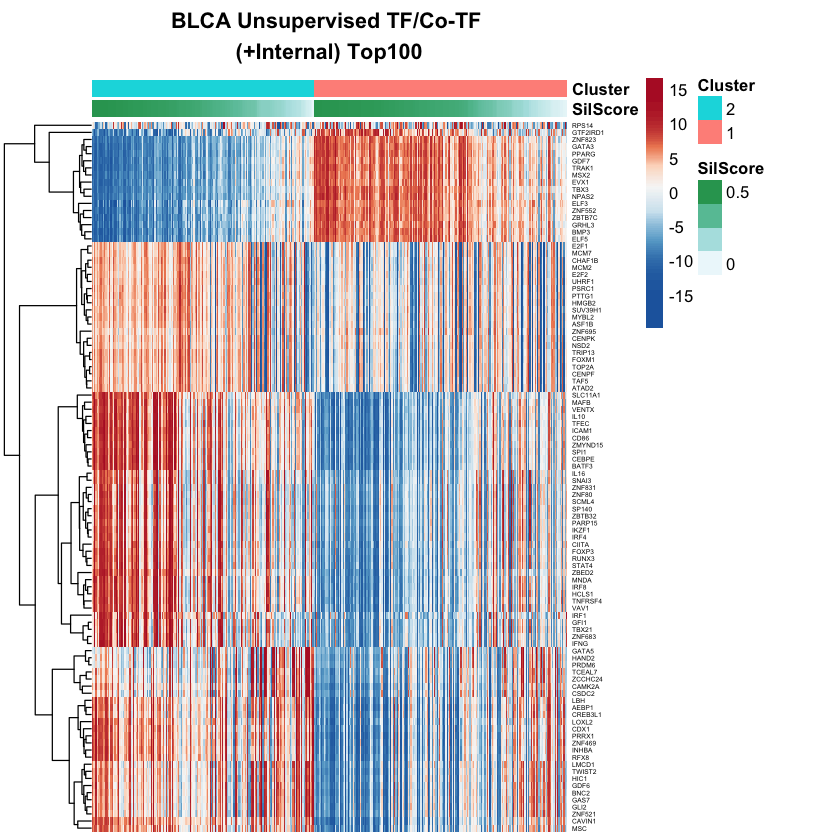

In [12]:
#restrict to top100 proteins only
var.keep.index <- apply(plot.data.tf.cotf,1,sd)
var.keep.index <- (rank(var.keep.index) > length(var.keep.index) - 100)

temp.plot.data.3 <- plot.data.tf.cotf[var.keep.index,]

mat_breaks <- quantile_breaks(temp.plot.data.3,n = 100)
rownames(temp.plot.data.3)<-getSYMBOL(rownames(temp.plot.data.3),data='org.Hs.eg')
test3<-pheatmap(temp.plot.data.3, color = colorRampPalette(rev(brewer.pal(n = 7, 
                                                                          name = "RdBu")))
                (length(mat_breaks)), fontsize_row = 4, fontsize_col = 5,
                main = "BLCA Unsupervised TF/Co-TF \n(+Internal) Top100",
                show_rownames = TRUE, show_colnames = FALSE, breaks = mat_breaks, 
                cluster_cols = FALSE, cluster_rows = TRUE, annotation_col = annot.col)
#save_pheatmap_pdf(test3,"BLCA_Unsupervised_TF_Co-TF_Int.top100.pdf")
#saveRDS(temp.plot.data.3,"BLCA.Unsup.top100.tf.cotf.Int.rds")


In [13]:
#Cluster-specific semi-supervised analysis

#samples in clusters
colnames(blca.tumor)<-gsub('.{16}$','',colnames(blca.tumor))

blca.samples.cl.1<-rownames(annot.col[which(annot.col$Cluster=='1'),])
blca.samples.cl.2<-rownames(annot.col[which(annot.col$Cluster=='2'),])

#cluster-specific protein activity
blca.mixed.cl.1 <- 
  mixed.tcga.tumor.normal[,intersect(blca.samples.cl.1,colnames(mixed.tcga.tumor.normal))]
dim(blca.mixed.cl.1)
#saveRDS(blca.mixed.cl.1,file = "blca.mixed.cl.1.rds")

blca.mixed.cl.2 <- 
  mixed.tcga.tumor.normal[,intersect(blca.samples.cl.2,colnames(mixed.tcga.tumor.normal))]
dim(blca.mixed.cl.2)
#saveRDS(blca.mixed.cl.2,file = "blca.mixed.cl.2.rds")


[1] 18133   202

[1] 18133   177

In [14]:
#match samples in clusters with samples with mutations
annot.1<-rownames(annot.col[which(annot.col$Cluster=='1'),])
#annot.1<-gsub('.{16}$','',annot.1)
annot.2<-rownames(annot.col[which(annot.col$Cluster=='2'),])
#annot.2<-gsub('.{16}$','',annot.2)

#pik3ca blca mutations
pik3ca.blca.Tumor_Sample_Barcode<-read.csv("../../PIK3CA_BLCA/pik3ca_mutations_blca_csv.csv",header=TRUE, sep=",")
rownames(pik3ca.blca.Tumor_Sample_Barcode) <- pik3ca.blca.Tumor_Sample_Barcode[,1]
pik3ca.blca.Tumor_Sample_Barcode<-pik3ca.blca.Tumor_Sample_Barcode[,-1]
#rownames(pik3ca.blca.Tumor_Sample_Barcode)

#rownames(EGFR.blca.Tumor_Sample_Barcode)<-gsub("\\-","\\.",rownames(EGFR.blca.Tumor_Sample_Barcode))
colnames(blca.tumor)<-gsub('.{16}$','',colnames(blca.tumor))
pik3ca.blca.samples<-blca.tumor[,intersect(rownames(pik3ca.blca.Tumor_Sample_Barcode),colnames(blca.tumor))]
dim(pik3ca.blca.samples)
#saveRDS(file=".pik3ca.blca.samples.rds")
dim(pik3ca.blca.samples)


[1] 18133    78

[1] 18133    78

In [15]:
#cluster-specific analysis
#separating out pik3ca-mut and pik3ca-wt samples from blca data in a cluster-specific manner
#cluster 1
blca.samples.cl.1<-colnames(blca.mixed.cl.1)
blca.samples.cl.1<-gsub('.{16}$','',blca.samples.cl.1)
blca.tum.cl.1 <- 
  blca.tumor[,intersect(blca.samples.cl.1,colnames(blca.tumor))]
dim(blca.tum.cl.1)
colnames(blca.tum.cl.1)<-gsub('.{16}$','',colnames(blca.tum.cl.1))
pik3ca.blca.tum.cl.1 <- 
  blca.tum.cl.1[,intersect(colnames(blca.tum.cl.1),colnames(pik3ca.blca.samples))]
dim(pik3ca.blca.tum.cl.1)
pik3ca.blca.wt.cl.1 <- 
  blca.tum.cl.1[,outersect(colnames(blca.tum.cl.1),colnames(pik3ca.blca.tum.cl.1))]
dim(pik3ca.blca.wt.cl.1)
#saveRDS(pik3ca.blca.wt.cl.1,file = "pik3ca.blca.wt.cl.1.rds")
#saveRDS(pik3ca.blca.tum.cl.1,file = "pik3ca.blca.tumor.cl.1.rds")

#cluster 1
blca.samples.cl.2<-colnames(blca.mixed.cl.2)
blca.samples.cl.2<-gsub('.{16}$','',blca.samples.cl.2)
blca.tum.cl.2 <- 
  blca.tumor[,intersect(blca.samples.cl.2,colnames(blca.tumor))]
dim(blca.tum.cl.2)
colnames(blca.tum.cl.2)<-gsub('.{16}$','',colnames(blca.tum.cl.2))
pik3ca.blca.tum.cl.2 <- 
  blca.tum.cl.2[,intersect(colnames(blca.tum.cl.2),colnames(pik3ca.blca.samples))]
dim(pik3ca.blca.tum.cl.2)
pik3ca.blca.wt.cl.2 <- 
  blca.tum.cl.2[,outersect(colnames(blca.tum.cl.2),colnames(pik3ca.blca.tum.cl.2))]
dim(pik3ca.blca.wt.cl.2)
#saveRDS(pik3ca.blca.wt.cl.2,file = "pik3ca.blca.wt.cl.2.rds")
#saveRDS(pik3ca.blca.tum.cl.2,file = "pik3ca.blca.tumor.cl.2.rds")


[1] 18133   195

[1] 18133    43

[1] 18133   152

[1] 18133   170

[1] 18133    37

[1] 18133   133

In [16]:
#cluster specific protein activity to identify pik3ca.wt closest to gtex bladder
#cluster 1
bladder_gtex<-read.table(file="../../PIK3CA_BLCA/bladder-gtex.txt", header=TRUE)
blca.normal<-bladder_gtex
dim(blca.normal)

identical(rownames(pik3ca.blca.tum.cl.1),rownames(pik3ca.blca.wt.cl.1))
table(rownames(pik3ca.blca.tum.cl.1)%in%rownames(pik3ca.blca.wt.cl.1))
common_genes <- intersect(rownames(pik3ca.blca.tum.cl.1),rownames(pik3ca.blca.wt.cl.1))
length(common_genes)

pik3ca.blca.tum.cl.1 <- pik3ca.blca.tum.cl.1[match(common_genes,rownames(pik3ca.blca.tum.cl.1)),]
pik3ca.blca.wt.cl.1 <- pik3ca.blca.wt.cl.1[match(common_genes,rownames(pik3ca.blca.wt.cl.1)),]
identical(rownames(pik3ca.blca.wt.cl.1),rownames(pik3ca.blca.tum.cl.1))

identical(rownames(blca.normal),rownames(pik3ca.blca.wt.cl.1))
table(rownames(blca.normal)%in%rownames(pik3ca.blca.wt.cl.1))
common_genes <- intersect(rownames(blca.normal),rownames(pik3ca.blca.wt.cl.1))
length(common_genes)

blca.normal <- blca.normal[match(common_genes,rownames(blca.normal)),]
pik3ca.blca.wt.cl.1 <- pik3ca.blca.wt.cl.1[match(common_genes,rownames(pik3ca.blca.wt.cl.1)),]
identical(rownames(pik3ca.blca.wt.cl.1),rownames(blca.normal))

#combining bladdar normal data with pik3ca blca in a cluster-specific manner
mixed.pik3ca.blca.cl.1 <- cbind(blca.normal, pik3ca.blca.wt.cl.1,pik3ca.blca.tum.cl.1)
dim(mixed.pik3ca.blca.cl.1)

#log2cpm+1 normalization
mixed.pik3ca.blca.cl.1.log2cpm <- apply(mixed.pik3ca.blca.cl.1,2,function(x){
  y <- 1E6*x/sum(x) + 1
  z <- log(y,2)
  return(z)
})

mixed.pik3ca.blca.cl.1.log2cpm.ges <- t(apply(mixed.pik3ca.blca.cl.1.log2cpm,1,function(x){
  y <- (x - mean(x))/sd(x)
  return(y)
}))
blca.normal.log2cpm <- apply(blca.normal,2,function(x){
  y <- 1E6*x/sum(x) + 1
  z <- log(y,2)
  return(z)
})
blca.normal.log2cpm.ges <- t(apply(blca.normal.log2cpm,1,function(x){
  y <- (x - mean(x))/sd(x)
  return(y)
}))

#viper using gtex
load('../../PIK3CA_BLCA/blca_regulon.rda')
pregul.blca<-regul
vipsig.mixed.pik3ca.blca.cl.1.gtex <- viperSignature(eset = as.matrix(mixed.pik3ca.blca.cl.1.log2cpm.ges), 
                                                    ref = as.matrix(blca.normal.log2cpm.ges), per = 1000, method = "ttest", 
                                                    verbose = TRUE)

vipermat.mixed.pik3ca.blca.cl.1.gtex <- viper(vipsig.mixed.pik3ca.blca.cl.1.gtex, pregul.blca,minsize = 25)
#saveRDS(vipermat.mixed.pik3ca.blca.cl.1.gtex,file="vipermat.mixed.pik3ca.blca.cl.1.gtex.rds")

pdf('density_estimation_pik3ca_blca_cluster_1.pdf')
plot(density(vipermat.mixed.pik3ca.blca.cl.1.gtex))
dev.off()


[1] 18133    11

[1] TRUE


 TRUE 
18133 

[1] 18133

[1] TRUE

[1] TRUE


 TRUE 
18133 

[1] 18133

[1] TRUE

[1] 18133   206

  |======================================================================| 100%


Computing the association scores

Computing regulons enrichment with aREA



  |======================================================================| 100%


Estimating NES with null model



  |======================================================================| 100%

pdf 
  2

In [17]:
#cluster 2
identical(rownames(pik3ca.blca.tum.cl.2),rownames(pik3ca.blca.wt.cl.2))
table(rownames(pik3ca.blca.tum.cl.2)%in%rownames(pik3ca.blca.wt.cl.2))
common_genes <- intersect(rownames(pik3ca.blca.tum.cl.2),rownames(pik3ca.blca.wt.cl.2))
length(common_genes)

pik3ca.blca.tum.cl.2 <- pik3ca.blca.tum.cl.2[match(common_genes,rownames(pik3ca.blca.tum.cl.2)),]
pik3ca.blca.wt.cl.2 <- pik3ca.blca.wt.cl.2[match(common_genes,rownames(pik3ca.blca.wt.cl.2)),]
identical(rownames(pik3ca.blca.wt.cl.2),rownames(pik3ca.blca.tum.cl.2))

identical(rownames(blca.normal),rownames(pik3ca.blca.wt.cl.2))
table(rownames(blca.normal)%in%rownames(pik3ca.blca.wt.cl.2))
common_genes <- intersect(rownames(blca.normal),rownames(pik3ca.blca.wt.cl.2))
length(common_genes)

blca.normal <- blca.normal[match(common_genes,rownames(blca.normal)),]
pik3ca.blca.wt.cl.2 <- pik3ca.blca.wt.cl.2[match(common_genes,rownames(pik3ca.blca.wt.cl.2)),]
identical(rownames(pik3ca.blca.wt.cl.2),rownames(blca.normal))

mixed.pik3ca.blca.cl.2 <- cbind(blca.normal, pik3ca.blca.wt.cl.2,pik3ca.blca.tum.cl.2)
dim(mixed.pik3ca.blca.cl.2)

#log2cpm+1 normalization
mixed.pik3ca.blca.cl.2.log2cpm <- apply(mixed.pik3ca.blca.cl.2,2,function(x){
  y <- 1E6*x/sum(x) + 1
  z <- log(y,2)
  return(z)
})

mixed.pik3ca.blca.cl.2.log2cpm.ges <- t(apply(mixed.pik3ca.blca.cl.2.log2cpm,1,function(x){
  y <- (x - mean(x))/sd(x)
  return(y)
}))
blca.normal.log2cpm <- apply(blca.normal,2,function(x){
  y <- 1E6*x/sum(x) + 1
  z <- log(y,2)
  return(z)
})
blca.normal.log2cpm.ges <- t(apply(blca.normal.log2cpm,1,function(x){
  y <- (x - mean(x))/sd(x)
  return(y)
}))

#viper using gtex
vipsig.mixed.pik3ca.blca.cl.2.gtex <- viperSignature(eset = as.matrix(mixed.pik3ca.blca.cl.2.log2cpm.ges), 
                                                    ref = as.matrix(blca.normal.log2cpm.ges), per = 1000, method = "ttest", 
                                                    verbose = TRUE)

vipermat.mixed.pik3ca.blca.cl.2.gtex <- viper(vipsig.mixed.pik3ca.blca.cl.2.gtex, pregul.blca,minsize = 25)
#saveRDS(vipermat.mixed.pik3ca.blca.cl.2.gtex,file="vipermat.mixed.pik3ca.blca.cl.2.gtex.rds")

pdf('density_estimation_pik3ca_blca_cluster_2.pdf')
plot(density(vipermat.mixed.pik3ca.blca.cl.2.gtex))
dev.off()


[1] TRUE


 TRUE 
18133 

[1] 18133

[1] TRUE

[1] TRUE


 TRUE 
18133 

[1] 18133

[1] TRUE

[1] 18133   181

  |======================================================================| 100%


Computing the association scores

Computing regulons enrichment with aREA



  |======================================================================| 100%


Estimating NES with null model



  |======================================================================| 100%

pdf 
  2

In [18]:
#Gaussian Mixture Model (GMM) on PIK3CA data
pik3ca.gmm.cl.1<-vipermat.mixed.pik3ca.blca.cl.1.gtex[match("5290",rownames(vipermat.mixed.pik3ca.blca.cl.1.gtex)),]
#saveRDS(pik3ca.gmm.cl.1,file="pik3ca.gmm.cl.1.rds")
pik3ca.gmm.cl.2<-vipermat.mixed.pik3ca.blca.cl.2.gtex[match("5290",rownames(vipermat.mixed.pik3ca.blca.cl.2.gtex)),]
#saveRDS(pik3ca.gmm.cl.2,file="pik3ca.gmm.cl.2.rds")


In [19]:
#compute the protein activity of all mutant samples vs. the WT
#with the protein activity most similar to GTEx
#cluster 1
dim(pik3ca.blca.wt.cl.1)
dim(pik3ca.blca.tum.cl.1)

identical(rownames(pik3ca.blca.tum.cl.1),rownames(pik3ca.blca.wt.cl.1))
table(rownames(pik3ca.blca.tum.cl.1)%in%rownames(pik3ca.blca.wt.cl.1))
common_genes <- intersect(rownames(pik3ca.blca.tum.cl.1),rownames(pik3ca.blca.wt.cl.1))
length(common_genes)

pik3ca.blca.tum.cl.1 <- pik3ca.blca.tum.cl.1[match(common_genes,rownames(pik3ca.blca.tum.cl.1)),]
pik3ca.blca.wt.cl.1 <- pik3ca.blca.wt.cl.1[match(common_genes,rownames(pik3ca.blca.wt.cl.1)),]
identical(rownames(pik3ca.blca.wt.cl.1),rownames(pik3ca.blca.tum.cl.1))

pik3ca.blca.wt.mut.cl.1 <- cbind(pik3ca.blca.wt.cl.1,pik3ca.blca.tum.cl.1)
dim(pik3ca.blca.wt.mut.cl.1)

#log2cpm+1 normalization
pik3ca.blca.wt.mut.cl.1.log2cpm <- apply(pik3ca.blca.wt.mut.cl.1,2,function(x){
  y <- 1E6*x/sum(x) + 1
  z <- log(y,2)
  return(z)
})

pik3ca.blca.wt.mut.cl.1.log2cpm.ges <- t(apply(pik3ca.blca.wt.mut.cl.1.log2cpm,1,function(x){
  y <- (x - mean(x))/sd(x)
  return(y)
}))
pik3ca.blca.wt.cl.1.log2cpm <- apply(pik3ca.blca.wt.cl.1,2,function(x){
  y <- 1E6*x/sum(x) + 1
  z <- log(y,2)
  return(z)
})

pik3ca.blca.wt.cl.1.log2cpm.ges <- t(apply(pik3ca.blca.wt.cl.1.log2cpm,1,function(x){
  y <- (x - mean(x))/sd(x)
  return(y)
}))

#viper using wt
vipsig.pik3ca.blca.wt.tum.cl.1 <- viperSignature(eset = as.matrix(pik3ca.blca.wt.mut.cl.1.log2cpm.ges), 
                                                ref = as.matrix(pik3ca.blca.wt.cl.1.log2cpm.ges), per = 1000, method = "ttest", 
                                                verbose = TRUE)

vipermat.pik3ca.blca.wt.tum.cl.1 <- viper(vipsig.pik3ca.blca.wt.tum.cl.1, pregul.blca,minsize = 25)
#saveRDS(vipermat.pik3ca.blca.wt.tum.cl.1,file="vipermat.pik3ca.blca.wt.tum.cl.1.rds")

pdf('density_estimation_pik3ca_blca_wt_tumor_cluster_1.pdf')
plot(density(vipermat.pik3ca.blca.wt.tum.cl.1))
dev.off()


[1] 18133   152

[1] 18133    43

[1] TRUE


 TRUE 
18133 

[1] 18133

[1] TRUE

[1] 18133   195

  |======================================================================| 100%


Computing the association scores

Computing regulons enrichment with aREA



  |======================================================================| 100%


Estimating NES with null model



  |======================================================================| 100%

pdf 
  2

In [20]:
dim(pik3ca.blca.wt.cl.2)
dim(pik3ca.blca.tum.cl.2)

identical(rownames(pik3ca.blca.tum.cl.2),rownames(pik3ca.blca.wt.cl.2))
table(rownames(pik3ca.blca.tum.cl.2)%in%rownames(pik3ca.blca.wt.cl.2))
common_genes <- intersect(rownames(pik3ca.blca.tum.cl.2),rownames(pik3ca.blca.wt.cl.2))
length(common_genes)

pik3ca.blca.tum.cl.2 <- pik3ca.blca.tum.cl.2[match(common_genes,rownames(pik3ca.blca.tum.cl.2)),]
pik3ca.blca.wt.cl.2 <- pik3ca.blca.wt.cl.2[match(common_genes,rownames(pik3ca.blca.wt.cl.2)),]
identical(rownames(pik3ca.blca.wt.cl.2),rownames(pik3ca.blca.tum.cl.2))

pik3ca.blca.wt.mut.cl.2 <- cbind(pik3ca.blca.wt.cl.2,pik3ca.blca.tum.cl.2)
dim(pik3ca.blca.wt.mut.cl.2)

#log2cpm+1 normalization
pik3ca.blca.wt.mut.cl.2.log2cpm <- apply(pik3ca.blca.wt.mut.cl.2,2,function(x){
  y <- 1E6*x/sum(x) + 1
  z <- log(y,2)
  return(z)
})

pik3ca.blca.wt.mut.cl.2.log2cpm.ges <- t(apply(pik3ca.blca.wt.mut.cl.2.log2cpm,1,function(x){
  y <- (x - mean(x))/sd(x)
  return(y)
}))
pik3ca.blca.wt.cl.2.log2cpm <- apply(pik3ca.blca.wt.cl.2,2,function(x){
  y <- 1E6*x/sum(x) + 1
  z <- log(y,2)
  return(z)
})

pik3ca.blca.wt.cl.2.log2cpm.ges <- t(apply(pik3ca.blca.wt.cl.2.log2cpm,1,function(x){
  y <- (x - mean(x))/sd(x)
  return(y)
}))

#viper using wt
vipsig.pik3ca.blca.wt.tum.cl.2 <- viperSignature(eset = as.matrix(pik3ca.blca.wt.mut.cl.2.log2cpm.ges), 
                                                ref = as.matrix(pik3ca.blca.wt.cl.2.log2cpm.ges), per = 1000, method = "ttest", 
                                                verbose = TRUE)

vipermat.pik3ca.blca.wt.tum.cl.2 <- viper(vipsig.pik3ca.blca.wt.tum.cl.2, pregul.blca,minsize = 25)
#saveRDS(vipermat.pik3ca.blca.wt.tum.cl.2,file="vipermat.pik3ca.blca.wt.tum.cl.2.rds")

pdf('density_estimation_pik3ca_blca_wt_tumor_cluster_2.pdf')
plot(density(vipermat.pik3ca.blca.wt.tum.cl.2))
dev.off()


[1] 18133   133

[1] 18133    37

[1] TRUE


 TRUE 
18133 

[1] 18133

[1] TRUE

[1] 18133   170

  |======================================================================| 100%


Computing the association scores

Computing regulons enrichment with aREA



  |======================================================================| 100%


Estimating NES with null model



  |======================================================================| 100%

pdf 
  2

In [21]:
#extracting pik3ca.mut samples from all the 2 clusters
# rownames(pik3ca.blca.Tumor_Sample_Barcode)<-gsub("\\-","\\.",rownames(pik3ca.blca.Tumor_Sample_Barcode))
vipermat.pik3ca.blca.wt.tum.cl.1.1<-vipermat.pik3ca.blca.wt.tum.cl.1
# colnames(vipermat.blca.cl.1.wt.1)<-gsub('.{16}$','',colnames(vipermat.blca.cl.1.wt.1))
vipermat.pik3ca.blca.tum.cl.1.1<- 
  vipermat.pik3ca.blca.wt.tum.cl.1.1[,intersect(rownames(pik3ca.blca.Tumor_Sample_Barcode),colnames(vipermat.pik3ca.blca.wt.tum.cl.1.1))]
dim(vipermat.pik3ca.blca.tum.cl.1.1)
vipermat.pik3ca.blca.wt.cl.1.1<- 
  vipermat.pik3ca.blca.wt.tum.cl.1.1[,outersect(colnames(vipermat.pik3ca.blca.wt.tum.cl.1.1),colnames(vipermat.pik3ca.blca.tum.cl.1.1))]
dim(vipermat.pik3ca.blca.wt.cl.1.1)

vipermat.pik3ca.blca.wt.tum.cl.2.1<-vipermat.pik3ca.blca.wt.tum.cl.2
# colnames(vipermat.blca.cl.1.wt.1)<-gsub('.{16}$','',colnames(vipermat.blca.cl.1.wt.1))
vipermat.pik3ca.blca.tum.cl.2.1<- 
  vipermat.pik3ca.blca.wt.tum.cl.2.1[,intersect(rownames(pik3ca.blca.Tumor_Sample_Barcode),colnames(vipermat.pik3ca.blca.wt.tum.cl.2.1))]
dim(vipermat.pik3ca.blca.tum.cl.2.1)
vipermat.pik3ca.blca.wt.cl.2.1<- 
  vipermat.pik3ca.blca.wt.tum.cl.2.1[,outersect(colnames(vipermat.pik3ca.blca.wt.tum.cl.2.1),colnames(vipermat.pik3ca.blca.tum.cl.2.1))]
dim(vipermat.pik3ca.blca.wt.cl.2.1)

#combine all pik3ca.mut samples into a single matrix
mix.pik3ca.blca.cl.1.2<-cbind(vipermat.pik3ca.blca.tum.cl.1.1,
                                 vipermat.pik3ca.blca.tum.cl.2.1)
dim(mix.pik3ca.blca.cl.1.2)
#saveRDS(mix.pik3ca.blca.cl.1.2,file="mix.pik3ca.blca.cl.1.2.rds")
#mix.pik3ca.blca.cl.1.2<-readRDS(file="mix.pik3ca.blca.cl.1.2.rds")

mix.pik3ca.blca.cl.1.2.wt<-cbind(vipermat.pik3ca.blca.wt.cl.1.1,
                                    vipermat.pik3ca.blca.wt.cl.2.1)
dim(mix.pik3ca.blca.cl.1.2.wt)
#saveRDS(mix.pik3ca.blca.cl.1.2.wt,file="mix.pik3ca.blca.cl.1.2.wt.rds")
#mix.pik3ca.blca.cl.1.2.wt<-readRDS(file="mix.pik3ca.blca.cl.1.2.wt.rds")


[1] 5679   43

[1] 5679  152

[1] 5679   37

[1] 5679  133

[1] 5679   80

[1] 5679  285

In [23]:
#downstream analysis
#mutations
mutation_file_pik3ca_blca<-read.csv("../../PIK3CA_BLCA/pik3ca_mutations_blca_csv.csv",header=TRUE, sep=",")
rownames(mutation_file_pik3ca_blca) <- mutation_file_pik3ca_blca[,1]
mutation_file_pik3ca_blca<-mutation_file_pik3ca_blca[,-1]
#rownames(mutation_file_pik3ca_blca)

vipermat.pik3ca.blca<-mix.pik3ca.blca.cl.1.2
common.rows <- intersect(colnames(vipermat.pik3ca.blca),rownames(mutation_file_pik3ca_blca))
length(common.rows)
mutation.file.1<-mutation_file_pik3ca_blca
mutation.file.1 <- mutation.file.1[match(common.rows,rownames(mutation.file.1)),]
dim(mutation.file.1)

annot.col.1.mutation.file.1<-mutation.file.1
dim(annot.col.1.mutation.file.1)
head(annot.col.1.mutation.file.1)
#saveRDS(annot.col.1.mutation.file.1,file="annot.col.1.mutation.file.1.pik3ca.blca.gof.new.rds")
#write.csv(annot.col.1.mutation.file.1,file="annot.col.1.mutation.file.1.pik3ca.blca.gof.new.csv")

test.1<-colnames(annot.col.1.mutation.file.1)
for(i in 1:length(test.1)) { 
  
  nam <- noquote(paste0(test.1[i], '.pik3ca.blca.samples'))
  # test.1[i]<-noquote(test.1[i])
  #t[i]<-noquote(test.1[i])
  nam.1 <- noquote(paste0(test.1[i]))
  #get(nam.1)
  assign(nam, (rownames(annot.col.1.mutation.file.1[which(annot.col.1.mutation.file.1[,nam.1]=='1'),])))
  # assign(nam, (blca.tcga.tumor[,intersect(colnames(blca.tcga.tumor),get(nam))]))
  
}

vipermat.plot.data.Int.gtex.c1.samples.2.copy<-vipermat.pik3ca.blca
test.1<-colnames(annot.col.1.mutation.file.1)
for(i in 1:length(test.1)) { 
  
  nam <- noquote(paste0(test.1[i], '.pik3ca.blca.samples.pik3ca'))
  # test.1[i]<-noquote(test.1[i])
  #t[i]<-noquote(test.1[i])
  nam.1 <- noquote(paste0(test.1[i],'.pik3ca.blca.samples'))
  #get(nam.1)
  # assign(nam, (rownames(annot.col.1.mutation.file.1[which(annot.col.1.mutation.file.1[,nam.1]=='1'),])))
  assign(nam, (vipermat.plot.data.Int.gtex.c1.samples.2.copy[,intersect(get(nam.1),colnames(vipermat.plot.data.Int.gtex.c1.samples.2.copy))]))
  
}


[1] 78

[1] 78 42

[1] 78 42

,E1012Q,E365K,E417K,E418K,E453K,E542K,E545A,E545G,E545K,E545Q,⋯,R115L,R274K,R88Q,R93Q,R992L,S499F,S66C,V151M,V636L,W552C
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
TCGA.2F.A9KO,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
TCGA.2F.A9KR,1,0,0,0,0,1,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
TCGA.4Z.AA7Y,0,0,0,0,0,0,0,1,1,0,⋯,0,0,0,0,0,0,0,0,0,0
TCGA.4Z.AA87,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,1,0
TCGA.4Z.AA89,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,1,0,0,0,0,0,0
TCGA.BT.A20Q,0,0,0,0,0,0,0,0,1,0,⋯,0,0,0,0,0,0,0,0,0,0


In [24]:
#domain-wise mutations
pik3ca_blca_all_labels<-cbind('E545Q','E726K','E1012Q','E365K','E417K',
                              'E418K','E453K','E545G','E600K','E710Q',
                              'E791Q','E978K','G1049R','G118D','G451V',
                              'H1047L','L671.','L752V','L956F',
                              'M1004V','M1043I','N345K','P471A','Q546K',
                              'Q546P','Q546R','R115L','R274K',
                              'R93Q','S499F','V151M','W552C','V636L',
                              'E545K','E542K','H1047R','R88Q'
)

#assigning labels as per mutation occurrence in domains
PI3K_p85B_32_108_pik3ca_blca_labels<-cbind(
  'R93Q','R88Q')
PI3K_rbd_174_291_pik3ca_blca_labels<-cbind('R274K'
)
PI3K_C2_351_483_pik3ca_blca_labels<-cbind('E365K','E417K',
                                          'E418K','E453K','G451V',
                                          'P471A')
PI3Ka_520_703_pik3ca_blca_labels<-cbind('E545Q','E545G','L671.','Q546K',
                                        'Q546P','Q546R',"E542K",  "E545K",  "E600K","W552C","V636L")
PI3_PI4_798_1014_pik3ca_blca_labels<-cbind('E978K','L956F',
                                           'M1004V',"E1012Q")

cbind_all<-cbind(PI3K_p85B_32_108_pik3ca_blca_labels,PI3K_rbd_174_291_pik3ca_blca_labels,
                 PI3K_C2_351_483_pik3ca_blca_labels,PI3Ka_520_703_pik3ca_blca_labels,
                 PI3_PI4_798_1014_pik3ca_blca_labels)

som3<-outersect(pik3ca_blca_all_labels,cbind_all)
length(som3)
Inter.domain.region.pik3ca_blca_labels<-som3
som3
Inter.domain.region.pik3ca_blca_labels<-cbind("E710Q",  "E726K",  "E791Q",  "G1049R",
                                              "G118D",  "H1047L", "H1047R", "L752V",
                                              "M1043I", "N345K",  "R115L", 
                                              "S499F",  "V151M")

#assigning samples with specific mutations to each domain-wise occurrence
PI3K_p85B_32_108_pik3ca_blca<-cbind(
  R93Q.pik3ca.blca.samples.pik3ca,R88Q.pik3ca.blca.samples.pik3ca)
PI3K_rbd_174_291_pik3ca_blca<-cbind(R274K.pik3ca.blca.samples.pik3ca
)
PI3K_C2_351_483_pik3ca_blca<-cbind(E365K.pik3ca.blca.samples.pik3ca,E417K.pik3ca.blca.samples.pik3ca,
                                   E418K.pik3ca.blca.samples.pik3ca,E453K.pik3ca.blca.samples.pik3ca,G451V.pik3ca.blca.samples.pik3ca,
                                   P471A.pik3ca.blca.samples.pik3ca)
PI3Ka_520_703_pik3ca_blca<-cbind(E545Q.pik3ca.blca.samples.pik3ca,E545G.pik3ca.blca.samples.pik3ca,L671..pik3ca.blca.samples.pik3ca,Q546K.pik3ca.blca.samples.pik3ca,
                                 Q546P.pik3ca.blca.samples.pik3ca,
                                 Q546R.pik3ca.blca.samples.pik3ca,E542K.pik3ca.blca.samples.pik3ca,  
                                 E545K.pik3ca.blca.samples.pik3ca,  
                                 E600K.pik3ca.blca.samples.pik3ca,
                                 W552C.pik3ca.blca.samples.pik3ca,V636L.pik3ca.blca.samples.pik3ca)
PI3_PI4_798_1014_pik3ca_blca<-cbind(E978K.pik3ca.blca.samples.pik3ca,L956F.pik3ca.blca.samples.pik3ca,
                                    M1004V.pik3ca.blca.samples.pik3ca,E1012Q.pik3ca.blca.samples.pik3ca)
Inter.domain.region.pik3ca_blca<-cbind(E710Q.pik3ca.blca.samples.pik3ca,  E726K.pik3ca.blca.samples.pik3ca,  E791Q.pik3ca.blca.samples.pik3ca,  G1049R.pik3ca.blca.samples.pik3ca,
                                       G118D.pik3ca.blca.samples.pik3ca,  H1047L.pik3ca.blca.samples.pik3ca, H1047R.pik3ca.blca.samples.pik3ca, L752V.pik3ca.blca.samples.pik3ca,
                                       M1043I.pik3ca.blca.samples.pik3ca, N345K.pik3ca.blca.samples.pik3ca,  R115L.pik3ca.blca.samples.pik3ca, 
                                       S499F.pik3ca.blca.samples.pik3ca,  V151M.pik3ca.blca.samples.pik3ca)

#integrating protein activity as per domains
current.stouffer.PI3K_p85B_32_108_pik3ca_blca <- apply(PI3K_p85B_32_108_pik3ca_blca,1,function(x){
  y <- sum(x)/sqrt(length(x))
  #y <- sum(w*x)/sqrt(sum(w^2))
  return(y)
})
current.stouffer.PI3K_C2_351_483_pik3ca_blca <- apply(PI3K_C2_351_483_pik3ca_blca,1,function(x){
  y <- sum(x)/sqrt(length(x))
  #y <- sum(w*x)/sqrt(sum(w^2))
  return(y)
})
current.stouffer.PI3Ka_520_703_pik3ca_blca <- apply(PI3Ka_520_703_pik3ca_blca,1,function(x){
  y <- sum(x)/sqrt(length(x))
  #y <- sum(w*x)/sqrt(sum(w^2))
  return(y)
})

current.stouffer.PI3_PI4_798_1014_pik3ca_blca <- apply(PI3_PI4_798_1014_pik3ca_blca,1,function(x){
  y <- sum(x)/sqrt(length(x))
  #y <- sum(w*x)/sqrt(sum(w^2))
  return(y)
})
current.stouffer.Inter.domain.region.pik3ca_blca <- apply(Inter.domain.region.pik3ca_blca,1,function(x){
  y <- sum(x)/sqrt(length(x))
  #y <- sum(w*x)/sqrt(sum(w^2))
  return(y)
})

#defining the matrix in the form of integrated protein activity
current.stouffer.domains.pik3ca.blca<-
  cbind(current.stouffer.PI3K_p85B_32_108_pik3ca_blca,
        PI3K_rbd_174_291_pik3ca_blca,
        current.stouffer.PI3K_C2_351_483_pik3ca_blca,
        current.stouffer.PI3Ka_520_703_pik3ca_blca,
        current.stouffer.PI3_PI4_798_1014_pik3ca_blca,
        current.stouffer.Inter.domain.region.pik3ca_blca)

colnames(current.stouffer.domains.pik3ca.blca)<- c('PI3K_p85B_32_108_pik3ca_blca',
                                                   'PI3K_rbd_174_291_pik3ca_blca',
                                                   'PI3K_C2_351_483_pik3ca_blca',
                                                   'PI3Ka_520_703_pik3ca_blca',
                                                   'PI3_PI4_798_1014_pik3ca_blca',
                                                   'Inter.domain.region')


[1] 13

[1] "E710Q"  "E726K"  "E791Q"  "G1049R" "G118D"  "H1047L" "H1047R" "L752V" 
 [9] "M1043I" "N345K"  "R115L"  "S499F"  "V151M"

[1] 2359

[1] 2359    6

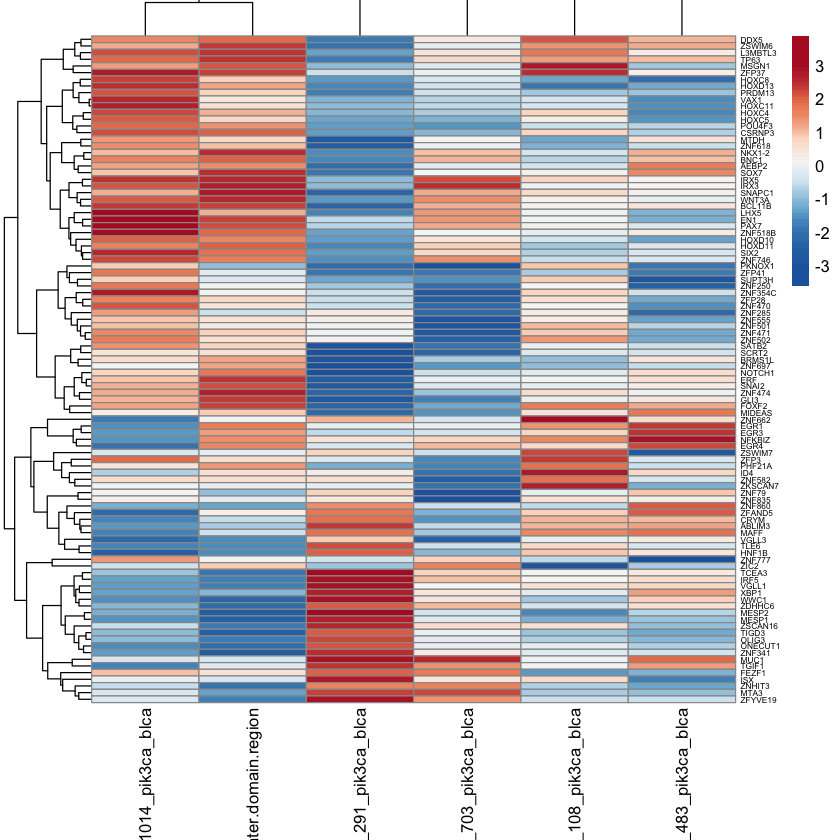

In [25]:
#intersecting tf/co-tf proteins with the entire protein activity matrix
common.tf.cotf.1 <- intersect(rownames(current.stouffer.domains.pik3ca.blca),rownames(tf.cotf))
length(common.tf.cotf.1)

all.domains.mutations.pik3ca.blca <- current.stouffer.domains.pik3ca.blca[match(common.tf.cotf.1,rownames(current.stouffer.domains.pik3ca.blca)),]
dim(all.domains.mutations.pik3ca.blca)

#rownames(all.domains.mutations.pik3ca.blca)<-getSYMBOL(rownames(all.domains.mutations.pik3ca.blca),data=org.Hs.eg)
zscore_data.1 <- t(apply(all.domains.mutations.pik3ca.blca,1,function(x){
  y <- (x - mean(x))/sd(x)
  return(y)
}))

rank.zscore_data.1 <- apply(zscore_data.1,2,rank)

keep.num.1 <- 2352
keep.index.1 <- apply(rank.zscore_data.1,1,function(x){
  y <- ((max(x) > (nrow(rank.zscore_data.1) + 1 - keep.num.1)) | min(x) <= keep.num.1)
  return(y)
})

temp.plot.data.2.1 <- all.domains.mutations.pik3ca.blca[keep.index.1,]

#mat_breaks <- quantile_breaks(temp.plot.data.2.1,n = 100)

#test3<-pheatmap(temp.plot.data.2.1, color = colorRampPalette(rev(brewer.pal(n = 7, 
#                                                                            name = "RdBu")))
#                (length(mat_breaks)), fontsize_row = 5, fontsize_col = 10,
#                main = "pik3ca.blca.TF.CoTF\nMutations.domain.wise.all",
#                show_rownames = FALSE, 
#                show_colnames = TRUE, 
#                breaks = mat_breaks, 
                #labels_col = as.character(colnames.current.stouffer.domains.egfr),
#                cellheight = 0.3,
                #  margins=c(100,100),
#                cluster_cols = TRUE, cluster_rows = TRUE,angle_col ="0")
#save_pheatmap_pdf(test3,"pik3ca.blca.Mutations.domain.wise.all.TF.CoTF.v3.pdf")
#saveRDS(temp.plot.data.2.1,file="pik3ca.tf.cotf.all.domain.wise.v3.rds")

#sorting the proteins to get top100
var.keep.index.1 <- apply(all.domains.mutations.pik3ca.blca,1,sd)
var.keep.index.1 <- (rank(var.keep.index.1) > length(var.keep.index.1) - 100)

temp.plot.data.3.1 <- all.domains.mutations.pik3ca.blca[var.keep.index.1,]

mat_breaks <- quantile_breaks(temp.plot.data.3.1,n = 100)

rownames(temp.plot.data.3.1)<-getSYMBOL(rownames(temp.plot.data.3.1),data='org.Hs.eg')

test3<-pheatmap(temp.plot.data.3.1, color = colorRampPalette(rev(brewer.pal(n = 7, 
                                                                            name = "RdBu")))
                (length(mat_breaks)), fontsize_row = 5, fontsize_col = 10,
                main = "pik3ca.blca.Top.100\nMutations.domain.wise",
                show_rownames = TRUE, show_colnames = TRUE, breaks = mat_breaks, 
                labels_col = as.character(colnames(current.stouffer.domains.pik3ca.blca)),
                cellheight = 4,
                cluster_cols = TRUE, cluster_rows = TRUE,angle_col ="90")
#save_pheatmap_pdf(test3,"pik3ca.blca.Mutations.domain.wise.top100.v3.pdf")
#saveRDS(temp.plot.data.3.1,file="pik3ca.tf.cotf.top100.domain.wise.v3.rds")


In [26]:
#mutation comparison - high confidence known gof vs unknown
high.conf.gof.pik3ca_blca_labels<-cbind(
  'E545K',
  'E542K',
  'H1047R',
  'R88Q')
high.conf.gof.P53_95_288_pik3ca_blca<-cbind(E545K.pik3ca.blca.samples.pik3ca,#2
                                            E542K.pik3ca.blca.samples.pik3ca,
                                            H1047R.pik3ca.blca.samples.pik3ca,#1
                                            #1
                                            R88Q.pik3ca.blca.samples.pik3ca)

PI3K_p85B_32_108_pik3ca_blca_others<-cbind(
  R93Q.pik3ca.blca.samples.pik3ca)
PI3K_rbd_174_291_pik3ca_blca<-cbind(R274K.pik3ca.blca.samples.pik3ca
)
PI3K_C2_351_483_pik3ca_blca<-cbind(E365K.pik3ca.blca.samples.pik3ca,E417K.pik3ca.blca.samples.pik3ca,
                                   E418K.pik3ca.blca.samples.pik3ca,E453K.pik3ca.blca.samples.pik3ca,G451V.pik3ca.blca.samples.pik3ca,
                                   P471A.pik3ca.blca.samples.pik3ca)
PI3Ka_520_703_pik3ca_blca_others<-cbind(E545Q.pik3ca.blca.samples.pik3ca,E545G.pik3ca.blca.samples.pik3ca,L671..pik3ca.blca.samples.pik3ca,Q546K.pik3ca.blca.samples.pik3ca,
                                        Q546P.pik3ca.blca.samples.pik3ca,
                                        Q546R.pik3ca.blca.samples.pik3ca,  
                                        
                                        E600K.pik3ca.blca.samples.pik3ca,
                                        W552C.pik3ca.blca.samples.pik3ca,V636L.pik3ca.blca.samples.pik3ca)
PI3_PI4_798_1014_pik3ca_blca<-cbind(E978K.pik3ca.blca.samples.pik3ca,L956F.pik3ca.blca.samples.pik3ca,
                                    M1004V.pik3ca.blca.samples.pik3ca,E1012Q.pik3ca.blca.samples.pik3ca)
Inter.domain.region.pik3ca_blca_others<-cbind(E710Q.pik3ca.blca.samples.pik3ca,  E726K.pik3ca.blca.samples.pik3ca,  E791Q.pik3ca.blca.samples.pik3ca,  G1049R.pik3ca.blca.samples.pik3ca,
                                              G118D.pik3ca.blca.samples.pik3ca,  H1047L.pik3ca.blca.samples.pik3ca,  L752V.pik3ca.blca.samples.pik3ca,
                                              M1043I.pik3ca.blca.samples.pik3ca, N345K.pik3ca.blca.samples.pik3ca,  R115L.pik3ca.blca.samples.pik3ca, 
                                              S499F.pik3ca.blca.samples.pik3ca,  V151M.pik3ca.blca.samples.pik3ca)


current.stouffer.high.conf.gof.P53_95_288_pik3ca_blca <- apply(high.conf.gof.P53_95_288_pik3ca_blca,1,function(x){
  y <- sum(x)/sqrt(length(x))
  #   #y <- sum(w*x)/sqrt(sum(w^2))
  return(y)
})
current.stouffer.PI3Ka_520_703_pik3ca_blca_others <- apply(PI3Ka_520_703_pik3ca_blca_others,1,function(x){
  y <- sum(x)/sqrt(length(x))
  #y <- sum(w*x)/sqrt(sum(w^2))
  return(y)
})
current.stouffer.Inter.domain.region.pik3ca_blca_others <- apply(Inter.domain.region.pik3ca_blca_others,1,function(x){
  y <- sum(x)/sqrt(length(x))
  #y <- sum(w*x)/sqrt(sum(w^2))
  return(y)
})

current.stouffer.high.conf.domains.pik3ca.blca<-
  cbind(current.stouffer.high.conf.gof.P53_95_288_pik3ca_blca,
        PI3K_p85B_32_108_pik3ca_blca_others,
        PI3K_rbd_174_291_pik3ca_blca,
        current.stouffer.PI3K_C2_351_483_pik3ca_blca,
        current.stouffer.PI3Ka_520_703_pik3ca_blca_others,
        current.stouffer.PI3_PI4_798_1014_pik3ca_blca,
        current.stouffer.Inter.domain.region.pik3ca_blca_others)

colnames(current.stouffer.high.conf.domains.pik3ca.blca)<- c("High.Conf.gof.P53_95_288 \n(E545K,E542K,H1047R,R88Q)",
                                                             'PI3K_p85B_32_108_pik3ca_blca_others',
                                                             'PI3K_rbd_174_291_pik3ca_blca',
                                                             'PI3K_C2_351_483_pik3ca_blca',
                                                             'PI3Ka_520_703_pik3ca_blca_others',
                                                             'PI3_PI4_798_1014_pik3ca_blca',
                                                             'Inter.domain.region')

#plotting the protein activity matrix
common.tf.cotf.1 <- intersect(rownames(current.stouffer.high.conf.domains.pik3ca.blca),rownames(tf.cotf))
length(common.tf.cotf.1)

all.domains.high.conf.mutations.pik3ca.blca <- current.stouffer.high.conf.domains.pik3ca.blca[match(common.tf.cotf.1,rownames(current.stouffer.high.conf.domains.pik3ca.blca)),]
dim(all.domains.high.conf.mutations.pik3ca.blca)

rownames(all.domains.high.conf.mutations.pik3ca.blca)<-getSYMBOL(rownames(all.domains.high.conf.mutations.pik3ca.blca),data='org.Hs.eg')
zscore_data.1 <- t(apply(all.domains.high.conf.mutations.pik3ca.blca,1,function(x){
  y <- (x - mean(x))/sd(x)
  return(y)
}))

rank.zscore_data.1 <- apply(zscore_data.1,2,rank)

keep.num.1 <- 2352
keep.index.1 <- apply(rank.zscore_data.1,1,function(x){
  y <- ((max(x) > (nrow(rank.zscore_data.1) + 1 - keep.num.1)) | min(x) <= keep.num.1)
  return(y)
})

temp.plot.data.2.1 <- all.domains.high.conf.mutations.pik3ca.blca[keep.index.1,]

#mat_breaks <- quantile_breaks(temp.plot.data.2.1,n = 100)

#test3<-pheatmap(temp.plot.data.2.1, color = colorRampPalette(rev(brewer.pal(n = 7, 
#                                                                            name = "RdBu")))
#                (length(mat_breaks)), fontsize_row = 5, fontsize_col = 8,
#                main = "pik3ca.blca.TF.CoTF\nHigh.Confidence.gof.Mutations.domain.wise.all\nKnown gof VS rest",
#                show_rownames = FALSE, 
#                show_colnames = TRUE, 
#                breaks = mat_breaks, 
                #labels_col = as.character(colnames.current.stouffer.domains.egfr),
#                cellheight = 0.30,
                #  margins=c(100,100),
#                cluster_cols = TRUE, cluster_rows = TRUE)
#save_pheatmap_pdf(test3,"pik3ca.blca.Mutations.domain.wise.all.TF.CoTF.high.conf.v3.pdf")
#saveRDS(temp.plot.data.2.1,file="pik3ca.blca.Mutations.domain.wise.all.TF.CoTF.high.conf.v3.rds")


[1] 2359

[1] 2359    7

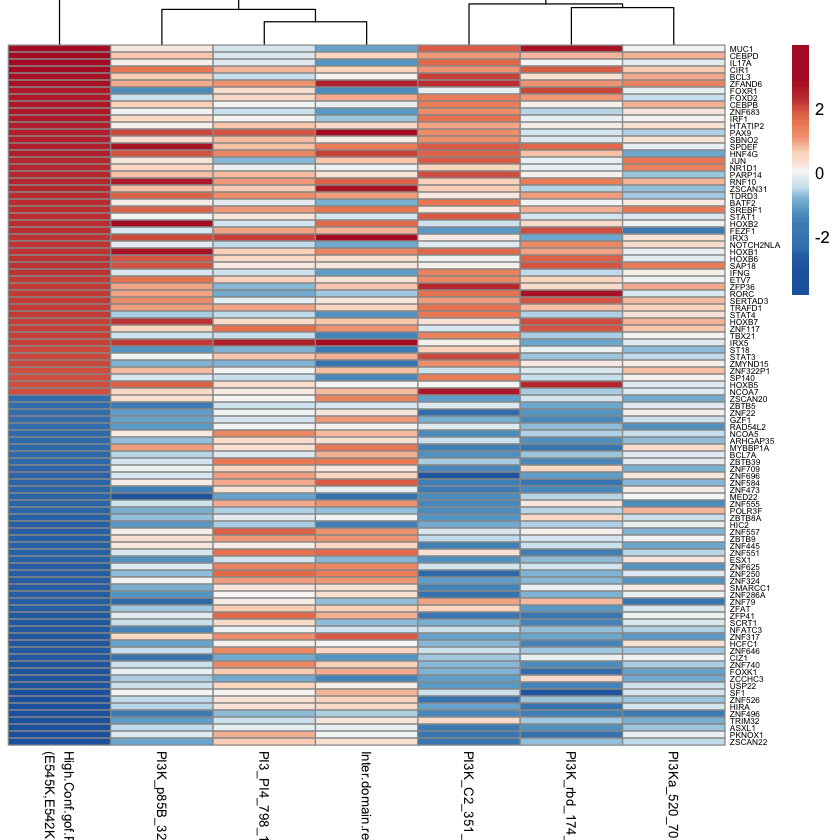

In [27]:
var.keep.index.1 <- apply(all.domains.high.conf.mutations.pik3ca.blca,1,sd)
var.keep.index.1 <- (rank(var.keep.index.1) > length(var.keep.index.1) - 2352)
#var.keep.index.1 <- (rank(var.keep.index.1) < length(var.keep.index.1) - 100)

temp.plot.data.3.1 <- all.domains.high.conf.mutations.pik3ca.blca[var.keep.index.1,]

mat_breaks <- quantile_breaks(temp.plot.data.3.1,n = 100)

#top 50 bottom50
common.tf.cotf.1 <- intersect(names(current.stouffer.high.conf.gof.P53_95_288_pik3ca_blca),rownames(tf.cotf))
cc.new<-current.stouffer.high.conf.gof.P53_95_288_pik3ca_blca[common.tf.cotf.1]
reference <- c(sort(cc.new,decreasing = TRUE)[1:50],rev(sort(cc.new,decreasing = FALSE)[1:50]))

# order the samples in the protein activity matrix by their enrichment and the rows by the protein activity in the consensus signature
protein.sort <- names(sort(reference,decreasing = TRUE))

# view results with a heatmap
protein.sort<-getSYMBOL(protein.sort,data='org.Hs.eg')

temp.plot.data.3.1 <- temp.plot.data.3.1[match(protein.sort,rownames(temp.plot.data.3.1)),]

mat_breaks <- quantile_breaks(temp.plot.data.3.1,n = 100)

#rownames(temp.plot.data.3.1)<-getSYMBOL(rownames(temp.plot.data.3.1),data='org.Hs.eg')

test3<-pheatmap(temp.plot.data.3.1,kmeans_k = NA,  color = colorRampPalette(rev(brewer.pal(n = 7, 
                                                                                           name = "RdBu")))
                (length(mat_breaks)), fontsize_row = 5, fontsize_col = 8,
                main = "pik3ca.blca.Top.50.Bottom.50\nHigh.Confidence.gof.Mutations.domain.wise.all\nKnown gof VS rest",
                show_rownames = TRUE, show_colnames = TRUE, breaks = mat_breaks, 
                cluster_cols = TRUE, cluster_rows = FALSE,cellheight = 4.2)

#save_pheatmap_pdf(test3,"pik3ca.blca.Mutations.domain.wise.top50.bottom50.high.conf.v3.pdf")
#saveRDS(temp.plot.data.3.1,file="pik3ca.blca.Mutations.domain.wise.top50.bottom50.high.conf.v3.rds")
#saveRDS(temp.plot.data.3.1[,1],file="pik3ca.blca.signature.rds")
#write.csv(temp.plot.data.3.1[,1],file="pik3ca.blca.signature.csv")


